# Macroscopic Modeling of Multi-Lane Traffic Flow Dynamics

TODO

## Table of Content

1. [Data Cleaning](#1.-Data-Cleaning)
2. [Plotting Microscopic Data](#2.-Plotting-Microscopic-Data) <br />
   2.1 [Ring Road](#2.1-Ring-Road) <br />
   2.2 [Highway](#2.2-Highway)
3. [Plotting Macroscopic Data](#3.-Plotting-Macroscopic-Data) <br />
   3.1 [Ring Road](#3.1-Ring-Road) <br />
   3.2 [Highway](#3.2-Highway)
4. [Time-Frequency Analysis of Macroscopic Data](#4.-Time-Frequency-Analysis-of-Macroscopic-Data) <br />
   4.1 [Ring Road](#4.1-Ring-Road) <br />
   4.2 [Highway](#4.2-Highway)
5. [Modeling Results](#5.-Modeling-Results) <br />
   5.1 [Lighthill-Whitham-Richards (LWR) Model](#5.1-Lighthill-Whitham-Richards-(LWR)-Model) <br />
   5.2 [Aw-Rascle-Zhang (ARZ) Model](#5.2-Aw-Rascle-Zhang-(ARZ)-Model) <br />
   5.3 [Linearized ARZ Model](#5.3-Linearized-ARZ-Model) <br />
   5.4 [Non-Local Model](#5.4-Non-Local-Model) <br />
   5.5 [Fully-Connected Neural Network](#5.5-Fully-Connected-Neural-Network)

## 1. Data Cleaning

We begin by performing some data cleaning. Sumo simulations within Flow generate emission csv files with several datapoints. For our purposes, we only care about the following:

* time: the timestamp of the given sample
* id: the name of the vehicle associated with this sample
* relative_position: the position of the vehicle on a given edge
* speed: the speed of the vehicle
* edge_id: the edge the vehicle is current residing on
* lane_number: the lane index of the vehicle, starting from 0 on the rightmost lane

Therefore, in order to reduce the size of the generate files, the below script trims out any unnecesary columns.

In [18]:
import pandas as pd
import os

# Specify the network type.
RING           = False
MERGE          = False
HIGHWAY_SINGLE = True
HIGHWAY_MULTI  = False

# Specify the directories containing the files you'd like to clean.
# directory = ["results/highway-single/baseline/sumo-idm/{}".format(x) 
#              for x in [2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000]]
directory = ["woop"]


for directory_i in directory:
    # get the names of all files in the directory
    files = os.listdir(directory_i)
    files.remove("micro")
    files.remove("macro")

    for i, fp in enumerate(sorted(files)):
        # import the next file
        df = pd.read_csv(os.path.join(directory_i, fp))

        # keep only the datapoints we care about
        df = df[["time", "id", "relative_position", "speed", "edge_id", "lane_number"]]

        if MERGE:
            df = df[(df.edge_id == 'inflow_highway')
                    | (df.edge_id =='left')
                    | (df.edge_id == 'center')
                    | (df.edge_id == ':center_0')
                    | (df.edge_id == ':center_1')]

        # save the new dataframe under the path micro/{i}.csv
        df.to_csv(os.path.join(directory_i, 'micro/{}.csv'.format(i)), index=False)

        # delete the dataframe
        del df

Next, we use the *edge_id* and *relative_position* data to generate global positions for each of the vehicles in the network, which we store under a new *global_position* attribute. The subsequent datapoints are removed, as they are no longer needed.

We begin by defining an absolute position term for the starting position of each edge on the network. This is defined in the `edgestarts` variable by the cell below. We do this for the ring road and highway networks. Modify the capitalized variable at the start of the cell to match the network you are using.

In [19]:
# specify the network type
RING           = False
MERGE          = False
HIGHWAY_SINGLE = True
HIGHWAY_MULTI  = False

# length of the ring road
RING_LENGTH = 1500

# length of the highway
MERGE_LENGTH = 1500

# position on the on-ramp merge on the highway
MERGE_POS = 1200

# length of the highway
HIGHWAY_LENGTH = 2500


if RING:
    # length of inter-edge junctions
    junction_length = 0.1

    edgestarts = {
        "bottom": 0,
        ":right_0": 0.25 * RING_LENGTH,
        "right": 0.25 * RING_LENGTH + junction_length,
        ":top_0": 0.5 * RING_LENGTH + junction_length,
        "top": 0.5 * RING_LENGTH + 2 * junction_length,
        ":left_0": 0.75 * RING_LENGTH + 2 * junction_length,
        "left": 0.75 * RING_LENGTH + 3 * junction_length,
        ":bottom_0": RING_LENGTH + 3 * junction_length
    }

if MERGE:
    # import network data from flow params
    inflow_edge_len = 100
    premerge = MERGE_POS - inflow_edge_len
    postmerge = MERGE_LENGTH - MERGE_POS

    # generate edge starts
    edgestarts = {
        'inflow_highway': 0,
        'left': inflow_edge_len + 0.1,
        'center': inflow_edge_len + premerge + 22.6,
        'inflow_merge': inflow_edge_len + premerge + postmerge + 22.6,
        'bottom': 2 * inflow_edge_len + premerge + postmerge + 22.7,
        ':left_0': inflow_edge_len,
        ':center_0': inflow_edge_len + premerge + 0.1,
        ':center_1': inflow_edge_len + premerge + 0.1,
        ':bottom_0': 2 * inflow_edge_len + premerge + postmerge + 22.6
    }

if HIGHWAY_SINGLE:
    edgestarts = {
        'highway_0': 0,
        ':edge_1_0': HIGHWAY_LENGTH / 2,
        'highway_1': HIGHWAY_LENGTH / 2 + 0.1,
    }


The below cell then performs the operation of adding global positions.

In [20]:
import pandas as pd
import os

directory = ["results/highway-single/baseline/sumo-idm/{}/micro".format(x) 
             for x in [2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000]]
directory = ["woop/micro"]

for directory_i in directory:
    # get the names of all files in the directory
    files = os.listdir(directory_i)

    for fp in files:
        print(directory_i, fp)
        # import the next file
        df = pd.read_csv(os.path.join(directory_i, fp))

        # create a column for the global positions
        df["global_position"] = 0

        # add the global position of the start of the edge
        for key in edgestarts.keys():
            df.loc[df.edge_id == key, "global_position"] = edgestarts[key]

        # add the relative position of the vehicles on the edge
        df.global_position += df.relative_position

        # remove the relative_position and edge_id columns
        df = df[["time", "id", "global_position", "speed", "lane_number"]]

        # save the new dataframe under the path i.csv
        df.to_csv(os.path.join(directory_i, fp), index=False)

        # delete the dataframe
        del df

woop/micro 0.csv


Finally, the below script generates meaningful macroscopic measurements from the available microscopic files. This is done by aggregates the densities and average speeds for sections of length `DX`. These aggregates can be collected for each lane separately by setting `INDIVIDUAL_LANES` to True.

In [10]:
import numpy as np
import math
import os
import csv
import time
from copy import deepcopy

# the discretization in space for the aggregation procedure
DX = 50
# the total length of the network (in meters)
LENGTH = 2500  # 1500
# the discretization of time during the simulation procedure
DT = 0.5
# the total simulation time (in seconds)
TOTAL_TIME = 1800
# whether to compute the speeds and densities for each lane separately
INDIVIDUAL_LANES = False


# Specify the directories containing the files you'd like to compute 
# macroscopic properties for.
directory = ["results/highway-single/baseline/sumo-idm/{}".format(x)
             for x in [3000]]


for directory_i in directory:
    directory_micro = os.path.join(directory_i, "micro")
    directory_macro = os.path.join(directory_i, "macro")

    # get the names of all files in the directory
    files = os.listdir(directory_micro)
    files = [fp for fp in files if fp.endswith(".csv")]

    for i, fp in enumerate(sorted(files)):
        # for timing purposes
        print(directory_i, i)
        t0 = time.time()

        speeds = np.zeros((round(TOTAL_TIME/DT)+1, round(LENGTH/DX)))
        num_vehicles = np.zeros((round(TOTAL_TIME/DT)+1, round(LENGTH/DX)))

        with open(os.path.join(directory_micro, fp)) as csvfile:
            # import the data
            reader = csv.DictReader(csvfile)

            # loop through each element
            for row in reader:
                indx_x = math.floor(float(row["time"]) / DT)
                indx_y = math.floor(float(row["global_position"]) / DX)

                try:
                    speeds[indx_x, indx_y] += float(row["speed"])
                    num_vehicles[indx_x, indx_y] += 1
                except IndexError:
                    # Flow adds an extra step
                    pass

        # place the new data in an output dictionary
        densities = num_vehicles / DX
        speeds[num_vehicles==0] = 30  # set max speed for zero density sections
        safe_num_vehicles = deepcopy(num_vehicles)
        safe_num_vehicles[safe_num_vehicles==0] = 1
        speeds = speeds / safe_num_vehicles.astype(float)
        num_sections = speeds.shape[1]
        output = {"time": np.arange(0, TOTAL_TIME+DT, DT)}
        output.update({"speed_{}".format(j): list(speeds[:, j]) for j in range(num_sections)})
        output.update({"density_{}".format(j): list(densities[:, j]) for j in range(num_sections)})

        # store in a csv file
        with open(os.path.join(directory_macro, "{}.csv".format(i)), "w") as outfile:
            writer = csv.writer(outfile)
            writer.writerow(output.keys())
            writer.writerows(zip(*output.values()))

        print(" Done: {} sec".format(time.time() - t0))

results/highway-single/baseline/sumo-idm/3000 0
 Done: 1.2036547660827637 sec
results/highway-single/baseline/sumo-idm/3000 1
 Done: 1.16267728805542 sec
results/highway-single/baseline/sumo-idm/3000 2
 Done: 1.0512158870697021 sec
results/highway-single/baseline/sumo-idm/3000 3
 Done: 1.09407639503479 sec
results/highway-single/baseline/sumo-idm/3000 4
 Done: 1.066406011581421 sec
results/highway-single/baseline/sumo-idm/3000 5
 Done: 1.1363887786865234 sec
results/highway-single/baseline/sumo-idm/3000 6
 Done: 1.301175832748413 sec
results/highway-single/baseline/sumo-idm/3000 7
 Done: 1.0817852020263672 sec
results/highway-single/baseline/sumo-idm/3000 8
 Done: 1.0759365558624268 sec
results/highway-single/baseline/sumo-idm/3000 9
 Done: 1.0602259635925293 sec
results/highway-single/baseline/sumo-idm/3000 10
 Done: 1.1385018825531006 sec
results/highway-single/baseline/sumo-idm/3000 11
 Done: 1.1890535354614258 sec
results/highway-single/baseline/sumo-idm/3000 12
 Done: 1.1100285053

The initial conditions from the above simulations can be extracted via the file below for later evaluations.

In [ ]:
import pandas as pd
import csv

LANES = 1
WARMUP_STEPS = 100


for n_vehicles in [50, 55, 60, 65, 70, 75]:
    new_data = []
    for i in range(50):
        # modify this path to match the dataset
        fp = "data/ring-1-lane/baseline/sumo-idm/{}/macro/{}.csv".format(LANES * n_vehicles, i)
        df = pd.read_csv(fp)
        df_i = df.iloc[WARMUP_STEPS, :]

        new_data_point = {}
        new_data_point.update({"speed_{}".format(i): df_i["speed_{}".format(i)] for i in range(30)})
        new_data_point.update({"density_{}".format(i): df_i["density_{}".format(i)] for i in range(30)})
        new_data.append(new_data_point)
        
        keys = new_data[0].keys()
        with open('initial_conditions_{}.csv'.format(n_vehicles), 'w') as output_file:
            dict_writer = csv.DictWriter(output_file, keys)
            dict_writer.writeheader()
            dict_writer.writerows(new_data)

## 2. Plotting Microscopic Data

We provide some supplementary methods for plotting time-space diagrams from the cleaned microscopic data. These plots are in many ways visually similar to the flow/density plots in the next section.

The below method is heavily adopted from this [link](https://github.com/flow-project/flow/blob/master/flow/visualize/time_space_diagram.py).

In [21]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.colors as colors


def time_space_diagram(df, 
                       lane=0, 
                       min_speed=0, 
                       max_speed=30, 
                       discontinuity=10,
                       title="Time-Space Diagram",
                       save_path=None):
    # leave only lane-relevant data
    df = df[df.lane_number == lane]

    # extract some variables from the dataset
    times = sorted(list(np.unique(df.time)))
    num_times = len(times)
    vehicles = sorted(list(np.unique(df.id)))
    num_vehicles = len(vehicles)

    # empty arrays for the positions and speeds of all vehicles
    pos = np.zeros((num_times, num_vehicles))
    speed = np.zeros((num_times, num_vehicles))

    # prepare the speed and absolute position in a way that is compatible with
    # the space-time diagram, and compute the number of vehicles at each step
    for j, veh_id in enumerate(vehicles):
        df_j = df[df.id == veh_id]
        pos_j = np.asarray(df_j.global_position)
        speed_j = np.asarray(df_j.speed)
        vehicle_times = np.asarray(df_j.time)
        for k, vehicle_time in enumerate(vehicle_times):
            index = times.index(vehicle_time)
            pos[index, j] = pos_j[k]
            speed[index, j] = speed_j[k]

    # some plotting parameters
    cdict = {
        'red': ((0, 0, 0), (0.2, 1, 1), (0.6, 1, 1), (1, 0, 0)),
        'green': ((0, 0, 0), (0.2, 0, 0), (0.6, 1, 1), (1, 1, 1)),
        'blue': ((0, 0, 0), (0.2, 0, 0), (0.6, 0, 0), (1, 0, 0))
    }
    my_cmap = colors.LinearSegmentedColormap('my_colormap', cdict, 1024)

    # perform plotting operation
    fig = plt.figure(figsize=(16, 9))
    ax = plt.axes()
    norm = plt.Normalize(min_speed, max_speed)
    cols = []

    xmin = times[0]
    xmax = times[-1]
    xbuffer = (xmax - xmin) * 0.025  # 2.5% of range
    ymin, ymax = np.amin(pos), np.amax(pos)
    ybuffer = (ymax - ymin) * 0.025  # 2.5% of range

    ax.set_xlim(xmin - xbuffer, xmax + xbuffer)
    ax.set_ylim(ymin - ybuffer, ymax + ybuffer)

    for indx_car in range(pos.shape[1]):
        unique_car_pos = pos[:, indx_car]

        # discontinuity from wraparound
        disc = np.where(np.abs(np.diff(unique_car_pos)) >= discontinuity)[0] + 1
        unique_car_time = np.insert(times, disc, np.nan)
        unique_car_pos = np.insert(unique_car_pos, disc, np.nan)
        unique_car_speed = np.insert(speed[:, indx_car], disc, np.nan)

        points = np.array(
            [unique_car_time, unique_car_pos]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap=my_cmap, norm=norm)

        # Set the values used for color mapping
        lc.set_array(unique_car_speed)
        lc.set_linewidth(1.75)
        cols.append(lc)

    plt.title(title, fontsize=25)
    plt.ylabel('Position (m)', fontsize=20)
    plt.xlabel('Time (s)', fontsize=20)

    for col in cols:
        line = ax.add_collection(col)
    cbar = plt.colorbar(line, ax=ax)
    cbar.set_label('Velocity (m/s)', fontsize=20)
    cbar.ax.tick_params(labelsize=18)

    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.clf()
    plt.close()

### 2.1 Ring Road

TODO

In [ ]:
LANES = 1

for n_vehicles in [50, 55, 60, 65, 70, 75]:
    for i in range(50):
        # modify this path to match the dataset
        fp = "data/ring-1-lane/baseline/sumo-idm/{}/micro/{}.csv".format(LANES * n_vehicles, i)
        df = pd.read_csv(fp)

        for lane in range(LANES):
            time_space_diagram(
                df,
                lane,
                min_speed=0,
                max_speed=30,
                title="",
                discontinuity=20,
                save_path=os.path.join(fp.rsplit('/', 1)[0], "ts-{}-{}.png".format(i, lane))
            )

### 2.2 Merge

TODO

In [ ]:
LANES = 1

for inflow in [1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]:
    for i in range(50):
        # modify this path to match the dataset
        fp = "data/merge-1-lane/baseline/sumo-idm/{}/micro/{}.csv".format(LANES * inflow, i)
        df = pd.read_csv(fp)

        for lane in range(LANES):
            time_space_diagram(
                df,
                lane,
                min_speed=0,
                max_speed=30,
                title="",
                discontinuity=20,
                save_path=os.path.join(fp.rsplit('/', 1)[0], "ts-{}-{}.png".format(i, lane))
            )

### 2.3 Highway (Single Lane)

TODO

In [22]:
LANES = 1

for inflow in [3000]:
    for i in range(50):
        # modify this path to match the dataset
        fp = "results/highway-single/baseline/sumo-idm/{}/micro/{}.csv".format(LANES * inflow, i)
        fp = "woop/micro/0.csv".format(LANES * inflow, i)
        df = pd.read_csv(fp)

        for lane in range(LANES):
            time_space_diagram(
                df,
                lane,
                min_speed=0,
                max_speed=30,
                title="",
                discontinuity=20,
                save_path=os.path.join(fp.rsplit('/', 1)[0], "ts-{}-{}.png".format(i, lane))
            )

/home/aboudy/.local/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


## 3. Plotting Macroscopic Data

We provide auxiliary methods for plotting the macroscopic traffic flow properties (i.e. flows and densities) from output files generating during the data cleaning procedure above. Examples of these plotting methods in action are available in the following subsections.

In [3]:
import pandas as pd
import numpy as np
import os


def avg_speed_plot(dir_path, sub_paths):
    # get the times from the first dataframe
    df = pd.read_csv(os.path.join(dir_path, "{}/micro/0.csv".format(sub_paths[0])))
    times = sorted(list(np.unique(df.time)))

    # empty arrays for the average speeds of all vehicles
    avg_speed = [[] for _ in range(len(sub_paths))]

    for i, path in enumerate(sub_paths):
        # extract the ".csv" file names
        filenames = os.listdir(os.path.join(dir_path, "{}/micro".format(path)))
        filenames = [fp for fp in filenames if fp.endswith(".csv")]

        for fp in filenames:
            print(path, fp)
            # get the dataframe
            full_path = os.path.join(dir_path, "{}/micro/{}".format(path, fp))
            df = pd.read_csv(full_path)

            avg_speeds_i = []
            for t in times:
                df_t = df[df.time==t]
                avg_speeds_i.append(np.mean(df_t.speed))

            avg_speed[i].append(avg_speeds_i)

        avg_speed[i] = np.array(avg_speed[i])        

    labels = sub_paths
    colors = plt.cm.get_cmap('tab10', len(labels)+1)
    fig = plt.figure(figsize=(16, 9))
    for i, (label, result) in enumerate(zip(labels, avg_speed)):
        plt.plot(times, np.mean(result, 0),
                 color=colors(i), linewidth=2, label=label)
        plt.fill_between(times,
                         np.mean(result, 0) - np.std(result, 0),
                         np.mean(result, 0) + np.std(result, 0),
                         alpha=0.25, color=colors(i))

    plt.ylabel('Velocity (m/s)', fontsize=20)
    plt.xlabel('Time (s)', fontsize=20)
    plt.tick_params(labelsize=15)
    plt.legend(fontsize=20)


def flow_density_plot(df, 
                      total_time,
                      length,
                      min_speed=0,
                      max_speed=30,
                      min_density=0,
                      max_density=0.2,
                      speed_save_path=None,
                      density_save_path=None,
                      flow_save_path=None):
    # some plotting parameters
    cdict = {
        'red': ((0, 0, 0), (0.2, 1, 1), (0.6, 1, 1), (1, 0, 0)),
        'green': ((0, 0, 0), (0.2, 0, 0), (0.6, 1, 1), (1, 1, 1)),
        'blue': ((0, 0, 0), (0.2, 0, 0), (0.6, 0, 0), (1, 0, 0))
    }
    my_cmap = colors.LinearSegmentedColormap('my_colormap', cdict, 1024)

    speed_columns = [c for c in df.columns if c.startswith("speed")]
    a = np.asarray(df[speed_columns]).T

    density_columns = [c for c in df.columns if c.startswith("density")]
    b = np.asarray(df[density_columns]).T

    c = a * b * 3600

    # Plot the average speed plots.
    plt.figure(figsize=(16,9))
    norm = plt.Normalize(min_speed, max_speed)
    plt.xlabel("Time (s)", fontsize=20)
    plt.ylabel("Position (m)", fontsize=20)
    plt.imshow(a, extent=(0,total_time,0,length), origin='lower', aspect='auto', cmap=my_cmap, norm=norm)
    cbar = plt.colorbar()
    cbar.set_label('Velocity (m/s)', fontsize=20)
    cbar.ax.tick_params(labelsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    if speed_save_path is not None:
        plt.savefig(speed_save_path, bbox_inches='tight')
    plt.clf()
    plt.close()
    
    # Plot the density plots.
    plt.figure(figsize=(16,9))
    norm = plt.Normalize(min_density, max_density)
    plt.xlabel("Time (s)", fontsize=20)
    plt.ylabel("Position (m)", fontsize=20)
    plt.imshow(b, extent=(0,total_time,0,length), origin='lower', aspect='auto', cmap=my_cmap, norm=norm)
    cbar = plt.colorbar()
    cbar.set_label('Density (veh/s)', fontsize=20)
    cbar.ax.tick_params(labelsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    if density_save_path is not None:
        plt.savefig(density_save_path, bbox_inches='tight')
    plt.clf()
    plt.close()

    # Plot the flow plots.
    plt.figure(figsize=(16,9))
    norm = plt.Normalize(min_speed * min_density * 3600, 0.2 * max_speed * max_density * 3600)
    plt.xlabel("Time (s)", fontsize=20)
    plt.ylabel("Position (m)", fontsize=20)
    plt.imshow(c, extent=(0,total_time,0,length), origin='lower', aspect='auto', cmap=my_cmap, norm=norm)
    cbar = plt.colorbar()
    cbar.set_label('flow (veh/hr)', fontsize=20)
    cbar.ax.tick_params(labelsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    if flow_save_path is not None:
        plt.savefig(flow_save_path, bbox_inches='tight')
    plt.clf()
    plt.close()

### 3.1 Ring Road

TODO

In [ ]:
# modify this path to match the dataset
DIR_PATH = "data/ring-1-lane/baseline/sumo-idm"
SUB_PATHS = ["50", "55", "60", "65", "70", "75"]

a = avg_speed_plot(DIR_PATH, SUB_PATHS)

In [ ]:
LANES = 1

for n_vehicles in [50, 55, 60, 65, 70, 75]:
    for i in range(50):
        # modify this path to match the dataset
        fp = "data/ring-1-lane/baseline/sumo-idm/{}/macro/{}.csv".format(LANES * n_vehicles, i)
        df = pd.read_csv(fp)

        flow_density_plot(
            df, 
            total_time=3600,
            length=1500,
            speed_save_path=os.path.join(fp.rsplit('/', 1)[0], "speed-{}.png".format(i)),
            density_save_path=os.path.join(fp.rsplit('/', 1)[0], "density-{}.png".format(i)),
            flow_save_path=os.path.join(fp.rsplit('/', 1)[0], "flow-{}.png".format(i))
        )

### 3.2 Merge

TODO

### 3.3 Highway

TODO

2000 16.csv
2000 19.csv
2000 17.csv
2000 15.csv
2000 12.csv
2000 10.csv
2000 35.csv
2000 9.csv
2000 31.csv
2000 24.csv
2000 42.csv
2000 39.csv
2000 0.csv
2000 29.csv
2000 32.csv
2000 21.csv
2000 33.csv
2000 43.csv
2000 36.csv
2000 5.csv
2000 41.csv
2000 4.csv
2000 23.csv
2000 38.csv
2000 44.csv
2000 22.csv
2000 20.csv
2000 25.csv
2000 18.csv
2000 6.csv
2000 34.csv
2000 49.csv
2000 47.csv
2000 2.csv
2000 13.csv
2000 7.csv
2000 14.csv
2000 40.csv
2000 37.csv
2000 11.csv
2000 46.csv
2000 45.csv
2000 30.csv
2000 1.csv
2000 28.csv
2000 8.csv
2000 48.csv
2000 3.csv
2000 26.csv
2000 27.csv
2100 16.csv
2100 19.csv
2100 17.csv
2100 15.csv
2100 12.csv
2100 10.csv
2100 35.csv
2100 9.csv
2100 31.csv
2100 24.csv
2100 42.csv
2100 39.csv
2100 0.csv
2100 29.csv
2100 32.csv
2100 21.csv
2100 33.csv
2100 43.csv
2100 36.csv
2100 5.csv
2100 41.csv
2100 4.csv
2100 23.csv
2100 38.csv
2100 44.csv
2100 22.csv
2100 20.csv
2100 25.csv
2100 18.csv
2100 6.csv
2100 34.csv
2100 49.csv
2100 47.csv
2100 2.csv
2100 13.

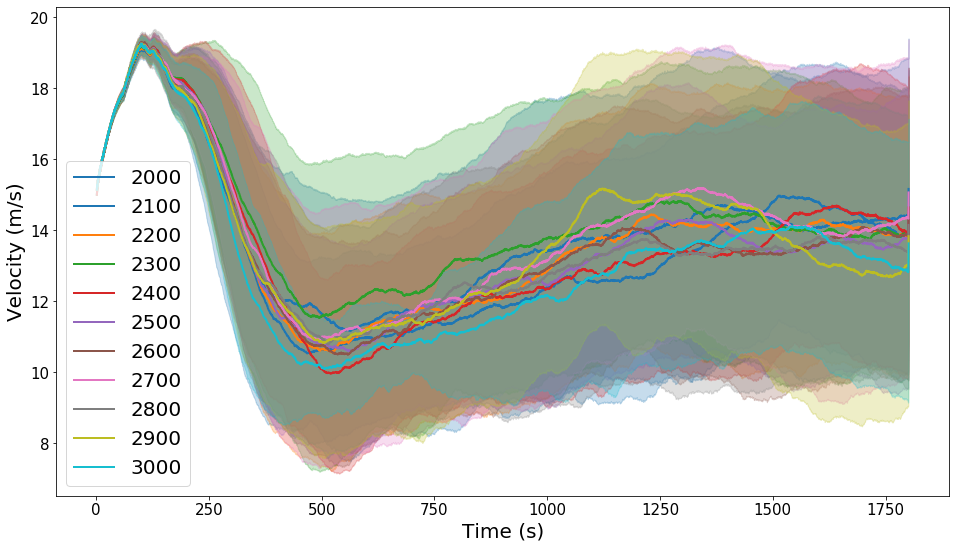

In [5]:
# modify this path to match the dataset
DIR_PATH = "results/highway-single/baseline/sumo-idm"
SUB_PATHS = ["2000", "2100", "2200", "2300", "2400",
             "2500", "2600", "2700", "2800", "2900", "3000"]

a = avg_speed_plot(DIR_PATH, SUB_PATHS)

In [4]:
LANES = 1

for inflow in [3000]:
    for i in range(50):
        # modify this path to match the dataset
        fp = "results/highway-single/baseline/sumo-idm/{}/macro/{}.csv".format(LANES * inflow, i)
        df = pd.read_csv(fp)

        flow_density_plot(
            df, 
            total_time=1800,
            length=2500,
            speed_save_path=os.path.join(fp.rsplit('/', 1)[0], "speed-{}.png".format(i)),
            density_save_path=os.path.join(fp.rsplit('/', 1)[0], "density-{}.png".format(i)),
            flow_save_path=os.path.join(fp.rsplit('/', 1)[0], "flow-{}.png".format(i))
        )

## 4. Time-Frequency Analysis of Macroscopic Data

TODO

### 4.1 Ring Road

TODO

### 4.2 Highway

TODO

## 5. Modeling Results

TODO

### 5.1 Lighthill-Whitham-Richards (LWR) Model

TODO

### 5.2 Aw-Rascle-Zhang (ARZ) Model

TODO

### 5.3 Linearized ARZ Model

TODO

### 5.4 Non-Local Model

TODO

### 5.5 Fully-Connected Neural Network

TODO